# StateGraph

> 使用 `StateGraph` 构建有向循环图

上一节，我们演示了如何使用 LangGraph 创建 Agent。然而，使用 Agent 调用 LLM 终究是隔了一层。我们将工具调用、流程控制的权力交给 Agent 的同时，也失去了对具体行为的掌控。

现在我们回到 LangGraph 底层，使用 `StateGraph` 直接控制代码执行。

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import RunnableConfig

# 加载模型配置
_ = load_dotenv()

In [2]:
# 加载模型
llm = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
    model="qwen3-coder-plus",
    temperature=0.7,
)

# 工具函数
@tool
def get_weather(city: str) -> str:
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"

# 创建工具节点
tools = [get_weather]
tool_node = ToolNode(tools)

# 创建助手节点
def assistant(state: MessagesState, config: RunnableConfig):
    system_prompt = 'You are a helpful assistant that can check weather.'
    all_messages = [SystemMessage(system_prompt)] + state['messages']
    model = llm.bind_tools(tools)
    return {'messages': [model.invoke(all_messages)]}

# 创建条件边
def should_continue(state: MessagesState, config: RunnableConfig):
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return 'continue'
    return 'end'

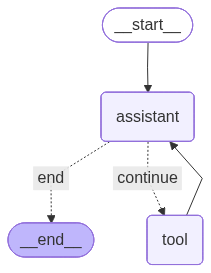

In [3]:
# 创建图
builder = StateGraph(MessagesState)

# 添加节点
builder.add_node('assistant', assistant)
builder.add_node('tool', tool_node)

# 添加边
builder.add_edge(START, 'assistant')

# 添加条件边
builder.add_conditional_edges(
    'assistant',
    should_continue,
    {
        'continue': 'tool',
        'end': END,
    },
)

# 添加边：调用工具节点后回到assistant
builder.add_edge('tool', 'assistant')

# 编译图
my_graph = builder.compile(name='my-graph')
my_graph

有向图分为：

- 有向无环图（DAG）
- 有向循环图（DCG）

从上图可以看出，我们使用 StateGraph 创建的是一个有向循环图。

In [4]:
# 调用图
response = my_graph.invoke({'messages': [HumanMessage(content='上海天气怎么样？')]})
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

上海天气怎么样？
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_e4a04b30a035493985be60c7)
 Call ID: call_e4a04b30a035493985be60c7
  Args:
    city: 上海
================================= Tool Message =================================
Name: get_weather

It's always sunny in 上海!
================================== Ai Message ==================================

上海的天气总是晴朗明媚！☀️ 如果你想了解更具体的天气信息，比如温度或降水概率，可以告诉我哦！
